In [ ]:
# This will be focusing more on the activations and gradients, as well as, batchnorm

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import os
%matplotlib inline

In [2]:
# read all words
words= open('names.txt', 'r').read().splitlines()

In [3]:
# build the vocabulary of characters and mapping to/from integers
chars= sorted(list(set(''.join(words))))
stoi= {s:i+1 for i,s in enumerate(chars)}
# build special characters for the start and end
stoi['.'] = 0
itos= {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

27


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

torch.manual_seed(2147483647)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(2147483647)

Using device: cuda


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X, dtype=torch.long, device=device)
  Y = torch.tensor(Y, dtype=torch.long, device=device)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# ----------------------------------------------------------
# MLP Initialization (GPU version)
# ----------------------------------------------------------

# Embedding dimensionality: how many numbers represent each character.
# Each character will be turned into a small dense vector of this size.
n_embd = 10

# Number of neurons in the hidden layer of the MLP.
# This determines the model’s capacity (larger = more expressive, slower).
n_hidden = 200

# Create a random number generator on the same device for reproducibility.
# Setting a fixed seed ensures consistent initialization and results.
g = torch.Generator(device=device).manual_seed(2147483647)

# Character embedding table:
# Each of the 'vocab_size' possible characters gets a learnable embedding vector of size n_embd.
# Using a normal distribution (randn) is common; its scale is fine since it's shallow.
C = torch.randn((vocab_size, n_embd), device=device)

# First linear layer weights: transforms flattened embeddings into hidden-layer activations.
# Shape = (input_dim, hidden_dim), where input_dim = n_embd * block_size - this is the FanIn.
# The multiplier (5/3)/sqrt(input_dim) is from a scaled version of Kaiming/He initialization.
# This scaling keeps the variance of activations roughly constant across layers, 
# which helps prevent exploding/vanishing activations when using tanh.
# These numbers can be found within the PyTorch init documentation for the different activation functions
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g, device=device) \
     * (5/3) / ((n_embd * block_size) ** 0.5)

# We do NOT need a bias vector 'b1' here because the BatchNorm layer that follows this linear layer
# already has its own bias parameter ('bnbias'). BatchNorm can shift and scale activations directly,
# making an explicit bias redundant. Including both would be unnecessary and slightly wasteful.
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01

# Second linear layer weights: project from hidden layer to output vocabulary logits.
# Initialized with a very small standard deviation (0.01) to keep early logits near zero.
# This keeps the softmax output initially close to uniform and prevents overly confident predictions
# before training adjusts the weights properly.
W2 = torch.randn((n_hidden, vocab_size), generator=g, device=device) * 0.01

# Output layer bias: usually safe to initialize to zero.
# This ensures all output classes start with equal prior probability.
# Setting it explicitly to 0 avoids introducing bias toward any class at the start.
b2 = torch.randn(vocab_size, generator=g, device=device) * 0

# Small epsilon constant used in BatchNorm division to prevent division-by-zero.
BN_EPS = 1e-5

# ----------------------------------------------------------
# Batch Normalization parameters
# ----------------------------------------------------------
# Resolvin issues of layers chasing and trying to account for chaning input statistics = internal covariate shift

# BatchNorm gain: a learnable scale factor applied after normalization.
# Initialized to 1 so it starts as a no-op (doesn’t change the normalized output).
bngain = torch.ones((1, n_hidden), device=device)

# BatchNorm bias: a learnable shift parameter applied after normalization.
# Initialized to 0 for the same reason as bngain — starts neutral.
bnbias = torch.zeros((1, n_hidden), device=device)

# Running mean: this tracks the moving average of activation means during training.
# Starts at zero since we haven’t seen any batches yet.
bnmean_running = torch.zeros((1, n_hidden), device=device)

# Running standard deviation: tracks moving average of activation stds.
# Starts at 1 so normalization doesn’t distort the activations before updates occur.
bnstd_running = torch.ones((1, n_hidden), device=device)

# ----------------------------------------------------------
# Collect parameters for optimization
# ----------------------------------------------------------

# We include all learnable tensors that require gradients.
# Note: bnmean_running and bnstd_running are buffers, not parameters — they’re updated manually.
parameters = [C, W1, W2, b2, bngain, bnbias]

# Print total number of parameters to get a sense of model size.
print(sum(p.nelement() for p in parameters), "parameters in total")

# Enable gradient tracking on all model parameters so autograd computes their gradients.
for p in parameters:
    p.requires_grad = True


In [ ]:
# 1) Ensure mapping + vocab are consistent
print("len(stoi) =", len(stoi), "vocab_size =", vocab_size)
assert vocab_size == len(stoi), "vocab_size must equal len(stoi)"

# 2) Ensure '.' exists and index 0 is what you expect (if you rely on it)
assert '.' in stoi, "stoi must include '.'"
print("stoi['.'] =", stoi['.'])

# 3) Ensure ALL tokens are in stoi
bad = [ch for w in words for ch in (w + '.') if ch not in stoi]
print("unknown chars:", set(bad))
assert len(bad) == 0, f"Unknown chars found: {set(bad)}"

# 4) Bounds checks for tensors actually used by CUDA
for name, X_, Y_ in [("train", Xtr, Ytr), ("dev", Xdev, Ydev), ("test", Xte, Yte)]:
    print(name, "X min/max:", int(X_.min()), int(X_.max()), "Y min/max:", int(Y_.min()), int(Y_.max()))
    assert int(X_.min()) >= 0 and int(X_.max()) < vocab_size, f"{name}: X out of bounds"
    assert int(Y_.min()) >= 0 and int(Y_.max()) < vocab_size, f"{name}: Y out of bounds"


### To understand BatchNormalization better

Imagine your network’s layers are chefs in a kitchen, passing ingredients from one to the next.
1. The first chef seasons the dish heavily.
2. The second chef expects mild seasoning but gets a salty mess.
3. The third chef has to adapt to that change.

Training becomes unstable because every time one layer updates its weights, the “ingredients” (input distributions) that the next layer receives keep changing.

BatchNorm acts like a quality control step between chefs:
> It ensures the ingredients that move between layers have a consistent flavor profile — i.e., mean and variance.

That stability lets each layer learn faster and more confidently.

__It stops layers from constantly chasing each other’s changing input statistics — a problem called internal covariate shift.__

#### For another Example of how it helps
Imagine each neuron’s output as a microphone signal in a concert hall.
- Without BatchNorm, some mics are whisper-quiet, others are blasting.
- BatchNorm automatically adjusts the volume and tone of each mic (normalizing to 0 mean, 1 variance) before mixing.

Then γ and β act as master volume and EQ knobs the system can fine-tune later.
So BatchNorm doesn’t just normalize — it gives each neuron a consistent dynamic range.


__The resulting goal of BatchNorm__
- Ensure guassian results
- This is to have mean roughly= 0 and mean roughly= 1

In [ ]:
# ----------------------------------------------------------
# OPTIMIZATION LOOP
# ----------------------------------------------------------
max_steps = 20000
batch_size = 32
lossi = []

# Make sure all model parameters are tracked for gradients
parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad_(True)

## REFER1:
# learning about a better way to use the decay on learning rate
# learn more about the torch.optim
import torch.optim as optim

# Create the optimizer once before the loop
optimizer = optim.SGD(parameters, lr=0.1)   # plain SGD
# or optimizer = optim.Adam(parameters, lr=1e-3)   # adaptive variant

# Optional scheduler to decay LR after 100 000 steps
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                           milestones=[max_steps/2],
                                           gamma=0.1)

# Training loop — computes forward pass, loss, backward, and update
for i in range(max_steps):

    # ---- Minibatch sampling ----
    # Randomly pick a batch of indices from the training set.
    # We draw directly on the GPU so tensors stay on the same device.
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g, device=device)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # ---- Forward pass ----
    # Embed each token into its vector representation
    emb = C[Xb]                                # Shape (B, T, E)
    # Flatten the embeddings into a single vector per example
    embcat = emb.view(emb.shape[0], -1)        # Shape (B, T*E)

    # First linear transformation (input → hidden)
    hpreact = embcat @ W1                      # Shape (B, n_hidden)

    # ---- Batch Normalization (training mode) ----
    # Compute mean and std for the current batch only.
    # These statistics are used to normalize the activations, stabilizing training.
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi  = hpreact.std(0, keepdim=True, unbiased=False)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi + BN_EPS) + bnbias

    # Update the running mean/std used later for inference (exponential moving average).
    # We do this inside torch.no_grad() because we don't want autograd to track it.
    with torch.no_grad():
        bnmean_running.mul_(0.999).add_(0.001 * bnmeani)
        bnstd_running.mul_(0.999).add_(0.001 * bnstdi)

    # ---- Non-linearity ----
    h = torch.tanh(hpreact)                    # Apply activation function
    # Output layer (hidden → vocab logits)
    logits = h @ W2 + b2
    # Cross-entropy automatically applies log-softmax and NLL
    loss = F.cross_entropy(logits, Yb)

    # ---- Backward pass ----
    # for p in parameters:
    #     p.grad = None                          # Zero gradients before backward
    optimizer.zero_grad(set_to_none=True)   # faster than manual loop
    
    loss.backward()                            # Compute gradients

    # ---- Parameter update ----
    # # Manual SGD update under torch.no_grad() so it’s not tracked by autograd.
    # lr = 0.1 if i < 100000 else 0.01
    ## THE UPDATED SECTION IS IN REFER1
    optimizer.step()
    scheduler.step()                        # adjusts LR if using scheduler

    ## SECTION BELOW COMMENTED OUT checkot REFER1
    # with torch.no_grad():
    #     for p in parameters:
    #         p -= lr * p.grad                   # Weight update (in-place)

    # ---- Logging ----
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

In [ ]:
plt.plot(lossi)

In [ ]:
# ----------------------------------------------------------
# BATCH NORM CALIBRATION AFTER TRAINING
# ----------------------------------------------------------
# At the end of training, we compute the true mean and std of the hidden layer
# across the entire training set. This ensures consistent normalization at inference.
# This isn't additional training - hence appointed by the no_grad. This is just running the full dataset (XTr) to see results
with torch.no_grad():
    emb     = C[Xtr]                           # Forward full training set
    embcat  = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    bnmean  = hpreact.mean(0, keepdim=True)    # True dataset mean
    bnstd   = hpreact.std(0, keepdim=True, unbiased=False)  # True dataset std

In [ ]:
# ----------------------------------------------------------
# LOSS EVALUATION FUNCTION
# ----------------------------------------------------------
# The @torch.no_grad() decorator disables autograd tracking.
# This saves memory and computation when gradients aren't needed.
# Here, we evaluate model loss for train/val/test splits.
@torch.no_grad()
def split_loss(split):
    # Select which dataset split to use
    x, y = {
        'train': (Xtr,  Ytr),
        'val':   (Xdev, Ydev),
        'test':  (Xte,  Yte),
    }[split]

    # Forward pass identical to training, except we use stored BN stats
    emb     = C[x]
    embcat  = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1

    # Use running mean/std for evaluation (or use bnmean/bnstd if calibrated)
    hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running + BN_EPS) + bnbias

    h      = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss   = F.cross_entropy(logits, y)
    print(split, loss.item())

# Compute and print evaluation losses
split_loss('train')
split_loss('val')

In [ ]:
@torch.no_grad()  # disable gradient tracking — sampling doesn't need grads
def sample_name(block_size, itos, use_calibrated=True, max_steps=100):
    """
    Generate a new sample (e.g., a name) one token at a time.
    Arguments:
      block_size: how many preceding characters to condition on
      itos: index-to-string mapping for decoding
      use_calibrated: if True, use the full-dataset mean/std computed earlier
      max_steps: safety cap on sequence length
    """
    # Start with a context of all '.' tokens (index 0), on the GPU
    context = torch.zeros((1, block_size), dtype=torch.long, device=device)
    out = []

    while True:
        # Embed the current context
        emb     = C[context]                      # Shape (1, T, E)
        B, T, E = emb.shape
        embcat  = emb.view(B, T * E)

        # Compute hidden activations
        hpreact = embcat @ W1

        # Normalize using calibrated or running batch norm stats
        if use_calibrated:
            hpreact = bngain * (hpreact - bnmean) / (bnstd + BN_EPS) + bnbias
        else:
            hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running + BN_EPS) + bnbias

        # Nonlinearity + output projection
        h      = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs  = F.softmax(logits, dim=1)         # Convert logits → probabilities

        # Randomly sample the next token index from the predicted distribution
        ix = torch.multinomial(probs[0], num_samples=1, generator=g).item()

        # Append token and update context (keep same block_size)
        out.append(ix)
        new_ix = torch.tensor([[ix]], dtype=torch.long, device=device)
        context = torch.cat([context[:, 1:], new_ix], dim=1)

        # Stop if we generate the '.' token (index 0) or reach the limit
        if ix == 0 or len(out) >= max_steps:
            break

    # Convert numeric indices back into characters and join them into a string
    return ''.join(itos[i] for i in out)

# Generate several samples
for _ in range(20):
    print(sample_name(block_size, itos, use_calibrated=True))


In [ ]:
# The initial loss has not been bad, but we can optimize further for initialization of weights
# initiial we want to aim for something like below
-torch.tensor(1/27.0).log()

In [32]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    # Educational: simple linear layer y = xW + b
    # - fan_in: number of input features (columns of x)
    # - fan_out: number of output features (columns of y)
    # - init: scale by 1/sqrt(fan_in) to keep activations/gradients well-behaved across depth
    # GPUvsCPU: Initialize parameters on the selected device (GPU if available)
    self.weight = torch.randn((fan_in, fan_out), generator=g, device=device) / fan_in**0.5
    # Educational: when followed by BatchNorm, bias is often redundant (BN has a learnable shift)
    self.bias = torch.zeros(fan_out, device=device) if bias else None
  
  def __call__(self, x):
    # Educational: x is (batch, fan_in), weight is (fan_in, fan_out) -> out is (batch, fan_out)
    # GPUvsCPU: Ensure inputs and parameters live on the same device
    if x.device != self.weight.device:
      raise RuntimeError(f'Device mismatch: x on {x.device}, weight on {self.weight.device}')
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    # Educational: expose learnable tensors to the optimizer
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps        # Educational: numerical stabilizer for sqrt(var + eps)
    self.momentum = momentum  # Educational: EMA factor for running stats (inference)
    self.training = True
    # GPUvsCPU: parameters (trained with backprop) are created on the same device
    self.gamma = torch.ones(dim, device=device)
    self.beta = torch.zeros(dim, device=device)
    # GPUvsCPU: buffers (running stats) also live on the same device
    self.running_mean = torch.zeros(dim, device=device)
    self.running_var = torch.ones(dim, device=device)
  
  def __call__(self, x):
    # Educational: normalize per-feature to zero-mean, unit-variance; then learnable scale/shift
    if self.training:
      xmean = x.mean(0, keepdim=True)  # batch mean
      # Use unbiased=False for stability on small batches / batch size 1
      xvar = x.var(0, keepdim=True, unbiased=False)  # batch variance (biased)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    # Educational: gamma (scale) and beta (shift) restore expressivity after normalization
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
# GPUvsCPU: Make RNG live on the same device as tensors (GPU when available)
g = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

# GPUvsCPU: Store embeddings directly on device to avoid CPU/CUDA index mismatch
C = torch.randn((vocab_size, n_embd), generator=g, device=device)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [ ]:
# # after you build Xtr/Ytr and know their device
# device = Xtr.device  # e.g., cuda:0

# # make sure C and all layer params live on that device
# C = C.to(device)

# Optimization setup
# Educational: train loop = sample minibatch -> forward -> loss -> backward -> update
max_steps = 200000
batch_size = 32
lossi = []   # Educational: track loss over time for plotting
ud = []      # Educational: track grad:data ratio as a rough health metric

## REFER1:
# learning about a better way to use the decay on learning rate
# learn more about the torch.optim
import torch.optim as optim

# Create the optimizer once before the loop
optimizer = optim.SGD(parameters, lr=0.1)   # Educational: plain SGD baseline
# or optimizer = optim.Adam(parameters, lr=1e-3)   # Educational: adaptive variant

# Optional scheduler to decay LR after half the steps (illustrates LR scheduling)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                           milestones=[max_steps/2],
                                           gamma=0.1)

for i in range(max_steps):
  
    # ---- Minibatch 
    # GPUvsCPU: sample indices and slice tensors on GPU to avoid device syncs
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), device=device)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # ---- Forward pass 
    emb = C[Xb]                                # Educational: lookup embeddings (B, T, E)
    x = emb.view(emb.shape[0], -1)             # Educational: flatten to (B, T*E) for MLP
    for layer in layers:
        x = layer(x)
    # Educational: cross-entropy expects logits (B, C) and targets (B)
    loss = F.cross_entropy(x, Yb)
  
    # ---- Backward pass ----
    # for p in parameters:
    #     p.grad = None                          # Zero gradients before backward
    optimizer.zero_grad(set_to_none=True)   # Educational: clear old grads efficiently
    
    loss.backward()                            # Educational: autograd computes d(loss)/d(params)

    # ---- Parameter update ----
    optimizer.step()                         # Educational: apply gradient step
    scheduler.step()                         # Educational: adjust LR if using scheduler
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())        # Educational: log-scale loss for nicer plots
    with torch.no_grad():
        # Educational: grad:data ratio per param (uses current optimizer LR)
        lr_current = optimizer.param_groups[0]['lr']
        ud.append([((lr_current * p.grad).std() / (p.data.std() + 1e-12)).log10().item()
                   for p in parameters if p.grad is not None])
    
    # if i >= 1000:
    #   break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2839
  10000/ 200000: 2.2405
  20000/ 200000: 2.5247
  30000/ 200000: 2.1980
  40000/ 200000: 2.3984
  50000/ 200000: 2.1899
  60000/ 200000: 1.8093
  70000/ 200000: 1.9797
  80000/ 200000: 1.7664
  90000/ 200000: 2.0764
 100000/ 200000: 2.2062
 110000/ 200000: 1.5938
 120000/ 200000: 2.2413
 130000/ 200000: 1.9762
 140000/ 200000: 2.6057
 150000/ 200000: 2.0672
 160000/ 200000: 2.6927
 170000/ 200000: 2.2866
 180000/ 200000: 1.8926
 190000/ 200000: 1.9590


layer 2 (      Tanh): mean -0.01, std 0.71, saturated: 16.94%
layer 5 (      Tanh): mean -0.02, std 0.75, saturated: 18.34%
layer 8 (      Tanh): mean +0.01, std 0.77, saturated: 19.16%
layer 11 (      Tanh): mean -0.01, std 0.77, saturated: 19.53%
layer 14 (      Tanh): mean -0.01, std 0.78, saturated: 18.97%


Text(0.5, 1.0, 'activation distribution')

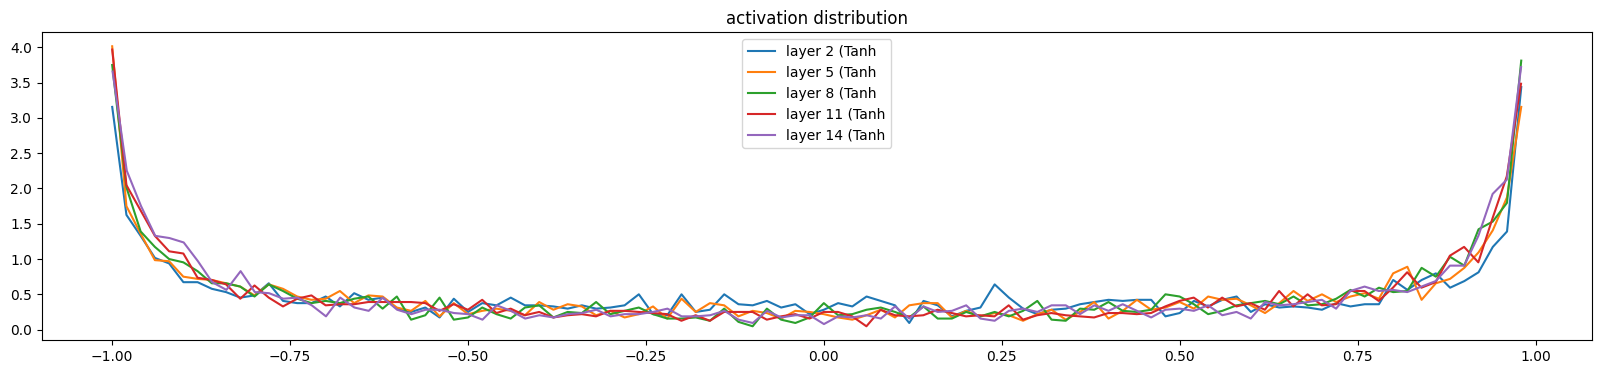

In [36]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    # Ensure a forward pass ran; histograms must use CPU tensors
    if not hasattr(layer, 'out'):
      continue
    t = layer.out
    # GPUvsCPU: Detach before scalar conversions to avoid autograd warnings
    tm = float(t.detach().mean().item())
    ts = float(t.detach().std().item())
    tsat = float(((t.detach().abs() > 0.97).float().mean().item()) * 100.0)
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, tm, ts, tsat))
    # GPUvsCPU: Move to CPU for torch.histogram + Matplotlib
    t_cpu = t.detach().float().cpu()
    hy, hx = torch.histogram(t_cpu, density=True)
    # GPUvsCPU: Plot expects CPU/NumPy arrays
    plt.plot(hx[:-1].numpy(), hy.numpy())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

Text(0.5, 1.0, 'gradient distribution')

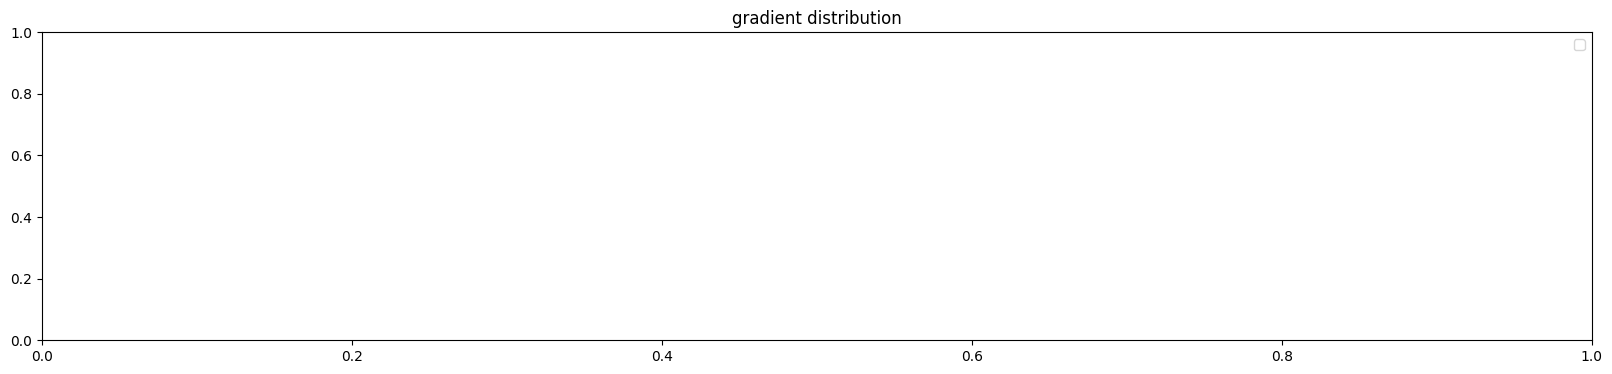

In [48]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    # Ensure forward+backward ran; histograms must use CPU tensors
    if not hasattr(layer, 'out') or layer.out.grad is None:
      continue
    t = layer.out.grad
    # GPUvsCPU: Detach before scalar conversions to avoid autograd warnings
    tm = float(t.detach().mean().item())
    ts = float(t.detach().std().item())
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, tm, ts))
    # GPUvsCPU: Move to CPU for torch.histogram + Matplotlib
    t_cpu = t.detach().float().cpu()
    hy, hx = torch.histogram(t_cpu, density=True)
    # GPUvsCPU: Plot expects CPU/NumPy arrays
    plt.plot(hx[:-1].numpy(), hy.numpy())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.273598e-02 | grad:data ratio 1.159259e-02
weight  (30, 100) | mean -0.000106 | std 8.391549e-03 | grad:data ratio 2.363616e-02
weight (100, 100) | mean +0.000043 | std 5.501872e-03 | grad:data ratio 2.577790e-02
weight (100, 100) | mean +0.000072 | std 6.093906e-03 | grad:data ratio 2.924295e-02
weight (100, 100) | mean +0.000041 | std 5.402640e-03 | grad:data ratio 2.693914e-02
weight (100, 100) | mean -0.000059 | std 4.894532e-03 | grad:data ratio 2.599772e-02
weight  (100, 27) | mean -0.000069 | std 7.791930e-03 | grad:data ratio 2.529719e-02


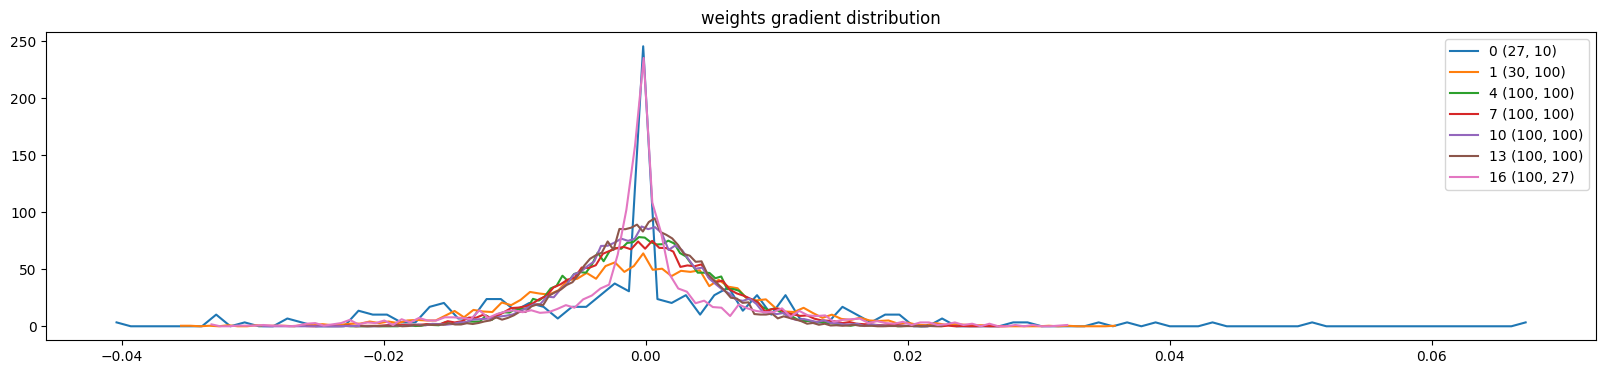

In [38]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    # Guard against missing grads if backward hasn't run yet
    if t is None:
      continue
    # GPUvsCPU: Detach before scalar conversions to avoid autograd warnings
    t_d = t.detach()
    p_d = p.detach()
    tm = float(t_d.mean().item())
    ts = float(t_d.std().item())
    pr = float(ts / (float(p_d.std().item()) + 1e-12))
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), tm, ts, pr))
    # GPUvsCPU: Move to CPU for torch.histogram + Matplotlib
    t_cpu = t.detach().float().cpu()
    hy, hx = torch.histogram(t_cpu, density=True)
    # GPUvsCPU: Plot expects CPU/NumPy arrays
    plt.plot(hx[:-1].numpy(), hy.numpy())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

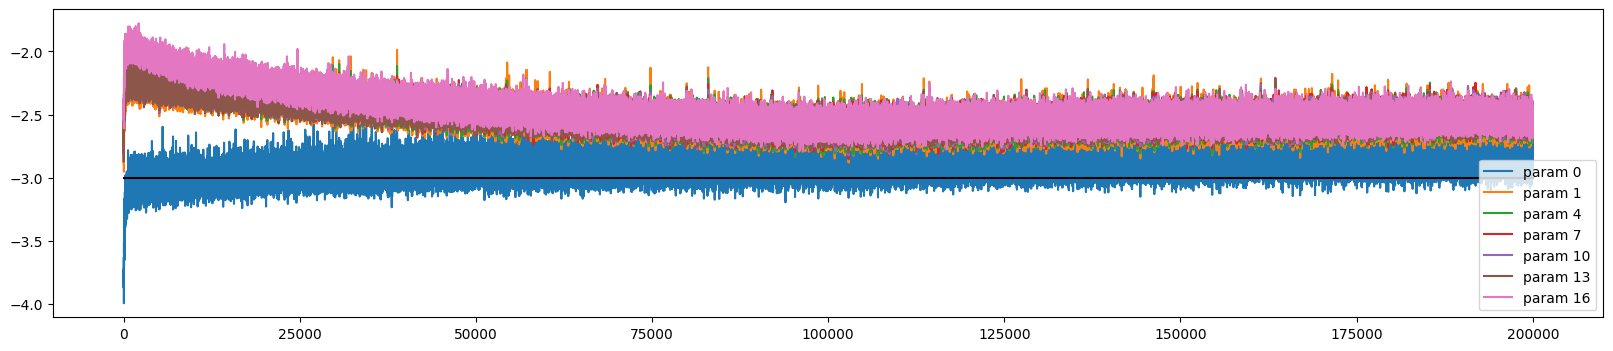

In [39]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [40]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.010268211364746
val 2.082897424697876


In [50]:
# sample from the model
# GPUvsCPU: Use a CUDA generator to match tensor device
# g = torch.Generator(device=device).manual_seed(2147483647 + 10)

# GPUvsCPU: Switch BatchNorm layers to inference to avoid per-batch stats with batch size 1
for layer in layers:
  if isinstance(layer, BatchNorm1d):
    layer.training = False

with torch.no_grad():
  for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      # GPUvsCPU: Index with a CUDA LongTensor so embedding lookup stays on GPU
      emb = C[torch.tensor([context], dtype=torch.long, device=device)] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

sarah.
seem.
aidah.
jary.
fela.
jacia.
deita.
kalylah.
zaleah.
avrie.
chadbert.
wir.
zailett.
tros.
ava.
keila.
net.
georgiovansy.
ilie.
stef.
